In [1]:
%%time
%matplotlib inline

import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import kaggle as kg

import keras
import tensorflow as tf

from scipy.linalg import sqrtm

from sklearn.utils import resample
from IPython.display import clear_output

from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras import backend
from tensorflow.keras.mixed_precision import set_global_policy

import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

import sys
import shutil
import winsound #This only work on windows, comment it out when working with other OS

sys.version
import session_info
session_info.show()

CPU times: total: 3 s
Wall time: 7.17 s


In [2]:
%%time
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available.")
        !nvidia-smi -L
    else:
        print("Training on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)
#tf.config.run_functions_eagerly(True)
AUTOTUNE = tf.data.experimental.AUTOTUNE

GPU is available.
GPU 0: NVIDIA GeForce RTX 3070 Laptop GPU (UUID: GPU-22e7aaac-adad-9a2f-120f-e4e0a027d5a6)
Number of replicas: 1
CPU times: total: 0 ns
Wall time: 1.22 s


In [3]:
#mixed precision to save resources use
tf.keras.mixed_precision.set_global_policy('mixed_float16')
#limits memory use. Kernel would crash if there is not enough avaliable memory. 
#Limiting it helps avoiding that at the cost of possible bottleneck.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6


In [4]:
%%time
datestr = time.strftime("%Y%m%d")
ROOT_DIR = "./"
DATA_DIR = "%s/data" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = ("%s/models/CGAN/"+ datestr) % ROOT_DIR
WEIGHTS_DIR = ("%s/weights/CGAN/"+ datestr) % ROOT_DIR
SAMPLES_DIR = ("%s/samples/CGAN/"+ datestr) % ROOT_DIR
GENERATED_DIR = "%s/generated" % ROOT_DIR

#Create missing directories, if they don't exist
if not os.path.exists(DATA_DIR):
    # Create a new directory because it does not exist
    os.makedirs(DATA_DIR)
    print("The data directory is created!")
if not os.path.exists(EVAL_DIR):
    # Create a new directory because it does not exist
    os.makedirs(EVAL_DIR)
    print("The evaluation directory is created!")
if not os.path.exists(MODEL_DIR):
    # Create a new directory because it does not exist
    os.makedirs(MODEL_DIR)
    print("The model directory is created!")
if not os.path.exists(WEIGHTS_DIR):
    # Create a new directory because it does not exist
    os.makedirs(WEIGHTS_DIR)
    print("The weights directory is created!")
if not os.path.exists(SAMPLES_DIR):
    # Create a new directory because it does not exist
    os.makedirs(SAMPLES_DIR)
    print("The samples directory is created!")
if not os.path.exists(GENERATED_DIR):
    # Create a new directory because it does not exist
    os.makedirs(GENERATED_DIR)
    print("The generated directory is created!")

CPU times: total: 0 ns
Wall time: 0 ns


%%time
kg.api.dataset_download_files(dataset = "shayanfazeli/heartbeat", path= DATA_DIR, unzip=True)

In [5]:
%%time
train_file_path = '%s/mitbih_train.csv' % DATA_DIR
column_names = [f"Point {i+1}" for i in range(187)] + ["label"]
df_train = pd.read_csv(train_file_path, names=column_names)
df_train["label"] = df_train["label"].astype(int)

CPU times: total: 1.95 s
Wall time: 2.53 s


In [6]:
%%time
img_rows = 187
img_cols = 1
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 256

# Number of classes in the dataset
num_classes = 5

# frequency for winsound beep is set to 262Hz (approximately middle C), please note that winsound only work on windows.
freq = 262
 
# duration is set to 1.5 seconds             
dur = 1500

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
%%time
def build_generator(z_dim):

    model = Sequential()
    
    #Layer 1
    model.add(Dense(512*4, input_dim=z_dim))
    model.add(Reshape((4, 512)))
    
    #Layer 2
    model.add(Conv1DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.02))

    #Layer 3
    model.add(Conv1DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.02))
    
    #Layer 4
    model.add(Conv1DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.02))

    #Layer 5
    model.add(Conv1DTranspose(1, kernel_size=4, strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.02))

    # Output layer with tanh activation
    model.add(Flatten())
    model.add(Dense(187))
    model.add(Reshape((187, 1)))
    model.add(Activation('tanh'))

    return model
#build_generator(z_dim).summary()

CPU times: total: 0 ns
Wall time: 0 ns


In [8]:
%%time
def build_cgan_generator(z_dim):

    # Random noise vector z
    z = Input(shape=(z_dim, ))

    # Conditioning label: integer 0-9 specifying the number G should generate
    label = Input(shape=(1, ), dtype='int32')

    # Label embedding:
    # ----------------
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape (batch_size, 1, z_dim)
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

    # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, z_dim)
    label_embedding = Flatten()(label_embedding)

    # Element-wise product of the vectors z and the label embeddings
    joined_representation = Multiply()([z, label_embedding])

    generator = build_generator(z_dim)

    # Generate image for the given label
    conditioned_img = generator(joined_representation)

    return Model([z, label], conditioned_img)
#build_cgan_generator(z_dim).summary()

CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
%%time
def build_discriminator(img_shape):

    model = Sequential()

    model.add(Input(shape = (img_shape[0], img_shape[1], img_shape[2] + 1)))
    
    #Layer 1
    model.add(
        Conv1D(32,
               kernel_size=4,
               strides=2,
               padding='same', use_bias=False))
    
    # Batch normalization
    #model.add(BatchNormalization())
    
    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))

    # Layer 2
    model.add(
        Conv1D(64,
               kernel_size=4,
               strides=2,
               padding='same', use_bias=False))

    # Batch normalization
    #model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))

    # Layer 3
    model.add(
        Conv1D(128,
               kernel_size=4,
               strides=2,
               padding='same', use_bias=False))

    # Batch normalization
    #model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model
#build_discriminator(img_shape).summary()

CPU times: total: 0 ns
Wall time: 0 ns


In [10]:
%%time
def build_cgan_discriminator(img_shape):

    # Input image
    img = Input(shape=img_shape)

    # Label for the input image
    label = Input(shape=(1, ), dtype='int32')

    #print("Shape of img:", img.shape)
    #print("Shape of label:", label.shape)

    # Label embedding:
    # ----------------
    # Turns labels into dense vectors of size z_dim
    # Produces 3D tensor with shape (batch_size, 1, 28*28*1)
    label_embedding = Embedding(num_classes,
                                np.prod(img_shape),
                                input_length=1)(label)

    # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, 28*28*1)
    label_embedding = Flatten()(label_embedding)

    # Reshape label embeddings to have same dimensions as input images
    label_embedding = Reshape(img_shape)(label_embedding)

    # Concatenate images with their label embeddings
    concatenated = Concatenate(axis=-1)([img, label_embedding])

    #print("Shape after concatenation:", concatenated.shape)

    discriminator = build_discriminator(img_shape)

    # Classify the image-label pair
    classification = discriminator(concatenated)

    return Model([img, label], classification)
#build_cgan_discriminator(img_shape).summary()

CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
%%time
def build_cgan(generator, discriminator):

    # Random noise vector z
    z = Input(shape=(z_dim, ))

    # Image label
    label = Input(shape=(1, ))

    # Generated image for that label
    img = generator([z, label])

    classification = discriminator([img, label])

    # Combined Generator -> Discriminator model
    # G([z, lablel]) = x*
    # D(x*) = classification
    model = Model([z, label], classification)

    return model

CPU times: total: 0 ns
Wall time: 0 ns


In [12]:
%%time
# Build and compile the Discriminator
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, clipvalue=1.0),
                      metrics=['accuracy'])

# Build the Generator
generator = build_cgan_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile CGAN model with fixed Discriminator to train the Generator
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, clipvalue=1.0))

CPU times: total: 1.14 s
Wall time: 1.72 s


In [13]:
def augment_data(data, noise_level = 0.1):
    """
    Adds noise to the non-padded region of the dataset, keeping data within [0, 1].
    
    Args:
        ecg_signal (numpy.ndarray): The input dataset of shape (n_samples, n_features).
                              Rows represent observations, columns represent time points.
        noise_level (float): Standard deviation of the Gaussian noise.
    
    Returns:
        numpy.ndarray: Dataset with noise added to the non-padded regions, clipped to [0, 1].
    """
    noisy_data = data.copy()
    for i, row in enumerate(data):
        # Find the last non-zero index
        non_padded_length = np.max(np.nonzero(row)) + 1
        if non_padded_length > 0:
            # Add Gaussian noise to the non-padded region
            noise = np.random.normal(0, noise_level, non_padded_length)
            noisy_data[i, :non_padded_length] += noise
            # Clip values to the range [0, 1]
            noisy_data[i, :non_padded_length] = np.clip(noisy_data[i, :non_padded_length], 0, 1)
    
    return noisy_data

In [14]:
def calculate_fid(df_real, df_generated):
    """
    Compute FID score between two pandas dataframes where:
    - Each row is a different signal
    - Each column is a data point of the signal

    Parameters:
        df_real (pd.DataFrame): DataFrame of real signals
        df_generated (pd.DataFrame): DataFrame of generated signals

    Returns:
        fid_score (float): Computed FID score
    """

    # Ensure inputs are either NumPy arrays or Pandas DataFrames
    if isinstance(df_real, np.ndarray):
        real_data = df_real
    elif hasattr(df_real, "to_numpy"):  # Handles Pandas DataFrame
        real_data = df_real.to_numpy()
    else:
        raise TypeError("df_real must be a NumPy array or Pandas DataFrame")

    if isinstance(df_generated, np.ndarray):
        gen_data = df_generated
    elif hasattr(df_generated, "to_numpy"):
        gen_data = df_generated.to_numpy()
    else:
        raise TypeError("df_generated must be a NumPy array or Pandas DataFrame")

    # Validate dimensions
    if real_data.shape[1] != gen_data.shape[1]:
        raise ValueError("Both datasets must have the same number of columns (features)")

    # Compute mean and covariance matrices
    mu_real, sigma_real = np.mean(real_data, axis=0), np.cov(real_data, rowvar=False)
    mu_gen, sigma_gen = np.mean(gen_data, axis=0), np.cov(gen_data, rowvar=False)

    # Compute square root of product of covariances
    cov_sqrt, _ = sqrtm(sigma_real @ sigma_gen, disp=False)

    # Check for numerical issues (complex numbers)
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real

    # Compute FID score
    fid_score = np.sum((mu_real - mu_gen) ** 2) + np.trace(sigma_real + sigma_gen - 2 * cov_sqrt)
    
    return fid_score

In [15]:
def compute_gradient_norms(model, loss_fn, x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)
    
    grads = tape.gradient(loss, model.trainable_variables)
    grad_norms = [tf.norm(g) for g in grads if g is not None]
    return grad_norms

In [16]:
%%time
accuracies = []
losses = []
#fid_scores = []
n_critic = []

def train(iterations, batch_size, sample_interval, n_discriminator = 1):

    print("Target number of iteration: " + str(iterations))
    print("Initial number of discriminator: " + str(n_discriminator))

    # Labels for real data
    real = np.ones((batch_size, 1))

    # Labels for fake data
    fake = np.zeros((batch_size, 1))

    sample_number = math.ceil(batch_size/5)
    
    for iteration in range(iterations):

        n_critic.append(n_discriminator)

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        for x in range(n_discriminator):

            # Generate labels
            # Labels for real data
            #real = np.random.uniform(0.9, 1.0, size=(batch_size, 1))
            
            # Labels for fake data
            #fake = np.random.uniform(0, 0.1, size=(batch_size, 1))
            
            # Sampling real data
            df_sample=df_train.groupby('label', group_keys=False).sample(n=math.ceil(batch_size/5))
            df_sample = df_sample.sample(frac=1)

            (X_train, y_train) = (df_sample.drop(['label'], axis=1).values, df_sample["label"].values)

            #X_train = augment_data(X_train, noise_level = 0.001)
            # Rescale values to [-1, 1]
            X_train = 2*X_train - 1.
            X_train = np.expand_dims(X_train, axis=2)

            # Get real batch
            imgs, labels = X_train, y_train

            # Generate fake batch
            z = np.random.normal(0, 1, (batch_size, z_dim))
            gen_imgs = generator.predict([z, y_train], verbose=0)

            # Train on real + fake data
            d_loss_real = discriminator.train_on_batch([X_train, y_train], real)
            d_loss_fake = discriminator.train_on_batch([gen_imgs, y_train], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # End of discriminator training loop

        # Check for discriminator output range
        fake_real = discriminator.predict([gen_imgs, y_train], verbose = 0)

        max_value = max(fake_real)
        min_value = min(fake_real)
            
        # Conditions to modify discriminator training frequency             
        if max_value < 0.75 and min_value > 0.25:
            #n_discriminator = n_discriminator+1
            print(f"\nIteration {iteration+1}/{iterations}", file=sys.__stdout__)
            print(f"D Acc Real: {100*d_loss_real[1]:.2f}% | D Acc Fake: {100*d_loss_fake[1]:.2f}% | D Acc: {100*d_loss[1]:.2f}%", file=sys.__stdout__)
            print(min_value, max_value, file=sys.__stdout__)
            print("discriminator might have difficulty differentiating real and fake", file=sys.__stdout__)
            print("increasing the number of discriminator loop", file=sys.__stdout__)
        
        elif d_loss[1] < 0.3:
            #n_discriminator = n_discriminator+1
            print(f"\nIteration {iteration+1}/{iterations}", file=sys.__stdout__)
            print(f"D Acc Real: {100*d_loss_real[1]:.2f}% | D Acc Fake: {100*d_loss_fake[1]:.2f}% | D Acc: {100*d_loss[1]:.2f}%", file=sys.__stdout__)
            print("discriminator accuracy is dangerously low", file=sys.__stdout__)
            print(min_value, max_value, file=sys.__stdout__)
            print("increasing the number of discriminator loop", file=sys.__stdout__)

        elif n_discriminator > 1 and d_loss[1] > 0.7:
            #n_discriminator = n_discriminator-1
            print(f"\nIteration {iteration+1}/{iterations}", file=sys.__stdout__)
            print(f"D Acc Real: {100*d_loss_real[1]:.2f}% | D Acc Fake: {100*d_loss_fake[1]:.2f}% | D Acc: {100*d_loss[1]:.2f}%", file=sys.__stdout__)
            print("discriminator accuracy is too high", file=sys.__stdout__)
            print(min_value, max_value, file=sys.__stdout__)
            print("decreasing the number of discriminator loop", file=sys.__stdout__)                   

        # ---------------------
        #  Train the Generator
        # ---------------------
        z = np.random.normal(0, 1, (batch_size, z_dim))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        g_loss = cgan.train_on_batch([z, y_train], np.ones((batch_size, 1)))

        losses.append((d_loss[0], g_loss))
        accuracies.append(100 * d_loss[1])
            
        if (iteration + 1) % sample_interval == 0 or (iteration + 1) == iterations:
            timestr = time.strftime("%Y%m%d-%H%M%S")
            print(f"\n{timestr}", file=sys.__stdout__)
            print(f"Iteration {iteration+1}/{iterations}", file=sys.__stdout__)
            print(f"D Loss: {d_loss[0]:.4f} | G Loss: {g_loss:.4f} | "
                  f"D Acc Real: {100*d_loss_real[1]:.2f}% | D Acc Fake: {100*d_loss_fake[1]:.2f}% | D Acc: {100*d_loss[1]:.2f}%", file=sys.__stdout__)
            name = str('%s/'+ timestr + '_CGAN_generator_' + str(iteration+1) + '.keras') % MODEL_DIR
            generator.compile(optimizer='adam', loss='binary_crossentropy')
            generator.save(name)
            name = str('%s/'+ timestr + '_CGAN_discriminator_' + str(iteration+1) + '.keras') % MODEL_DIR
            discriminator.save(name)
            name = str('%s/'+ timestr + '_CGAN_gan_' + str(iteration+1) + '.keras') % MODEL_DIR
            cgan.save(name)
            name = str('%s/'+ timestr + '_CGAN_generator_' + str(iteration+1) + '.weights.h5') % WEIGHTS_DIR
            generator.save_weights(name)
            name = str('%s/'+ timestr + '_CGAN_discriminator_' + str(iteration+1) + '.weights.h5') % WEIGHTS_DIR
            discriminator.save_weights(name)
            name = str('%s/'+ timestr + '_CGAN_gan_' + str(iteration+1) + '.weights.h5') % WEIGHTS_DIR
            cgan.save_weights(name)
            
            name = str('%s/'+ timestr + 'losses_CGAN' + str(iteration+1)) % MODEL_DIR
            np.save(name, losses)
            name = str('%s/'+ timestr + 'accuracy_CGAN' + str(iteration+1)) % MODEL_DIR
            np.save(name, accuracies)

            sample_images(iteration)
            
    print("We have reached the end of training")
    print("Number of Discriminator at the end is: ", n_discriminator)
    winsound.Beep(freq, dur)
    winsound.Beep(freq*2, dur)

CPU times: total: 0 ns
Wall time: 0 ns


In [17]:
%%time
def sample_images(iteration,image_grid_rows=10, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-4
    label = np.arange(0, 5)
    labels = np.tile(label, image_grid_rows).reshape(-1, 1)

    # Generate images from random noise
    gen_imgs = generator.predict([z, labels], verbose=0)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(20, 35))

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].plot(gen_imgs[cnt, :].reshape(-1,))
            axs[i, j].set_title("label: %d" % labels[cnt])
            cnt += 1
    timestr = time.strftime("%Y%m%d-%H%M%S")
    name = str('%s/'+ timestr + '_CGAN_' + str(iteration+1) + '.png') % SAMPLES_DIR
    fig.savefig(name)
    plt.close()

CPU times: total: 0 ns
Wall time: 0 ns


In [18]:
%%time
# Set hyperparameters
iterations = 500
batch_size = 200
sample_interval = 25
n_discriminator = 154

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
generator_file_path = "%s/../20250215/20250215-094956_CGAN_generator_500.weights.h5" % WEIGHTS_DIR
generator.load_weights(generator_file_path, skip_mismatch=False, by_name=False, options=None)
#generator = tf.keras.models.load_model(generator_file_path)

In [20]:
discriminator_file_path = "%s/../20250215/20250215-094956_CGAN_discriminator_500.weights.h5" % WEIGHTS_DIR
discriminator.load_weights(discriminator_file_path, skip_mismatch=False, by_name=False, options=None)
#discriminator = tf.keras.models.load_model(discriminator_file_path)

In [21]:
%%time
# Train the CGAN for the specified number of iterations
train(iterations, batch_size, sample_interval, n_discriminator)

Target number of iteration: 500
Initial number of discriminator: 154
We have reached the end of training
Number of Discriminator at the end is:  154
CPU times: total: 3h 27min 46s
Wall time: 8h 27min 8s


In [22]:
winsound.Beep(freq*2, dur)
winsound.Beep(freq, dur)

CPU times: total: 15.6 ms
Wall time: 34.4 ms


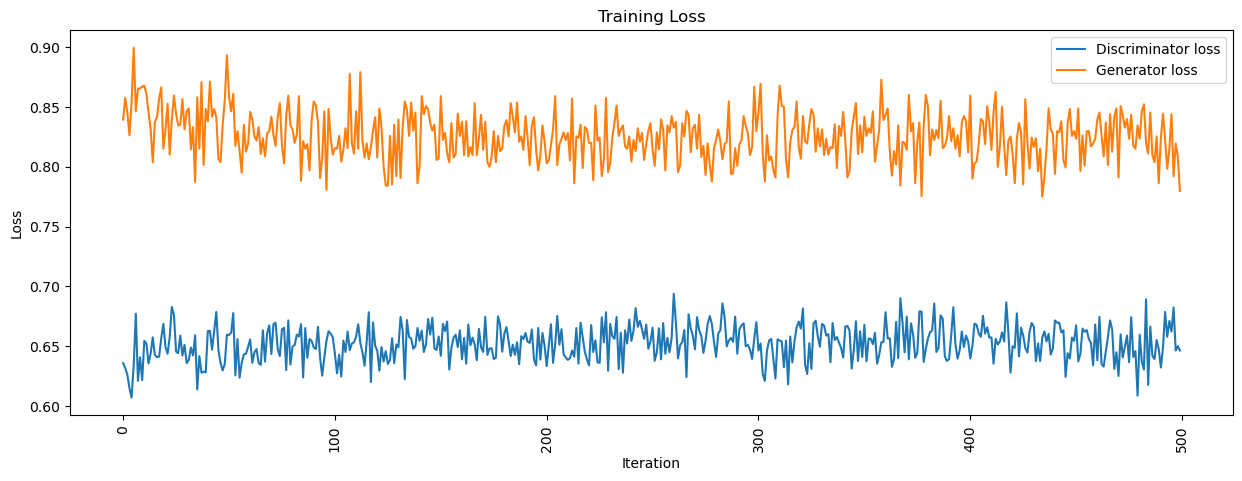

In [23]:
%%time
loss = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(loss.T[0], label="Discriminator loss")
plt.plot(loss.T[1], label="Generator loss")

plt.xticks(rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

CPU times: total: 15.6 ms
Wall time: 51.9 ms


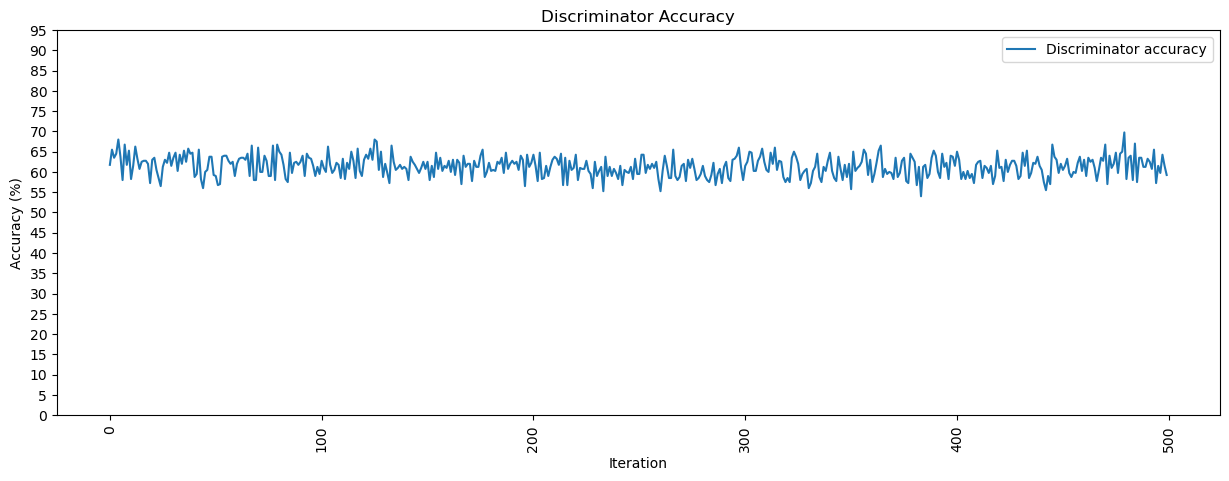

In [24]:
%%time
acc = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(acc, label="Discriminator accuracy")

plt.xticks(rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

CPU times: total: 0 ns
Wall time: 39.2 ms


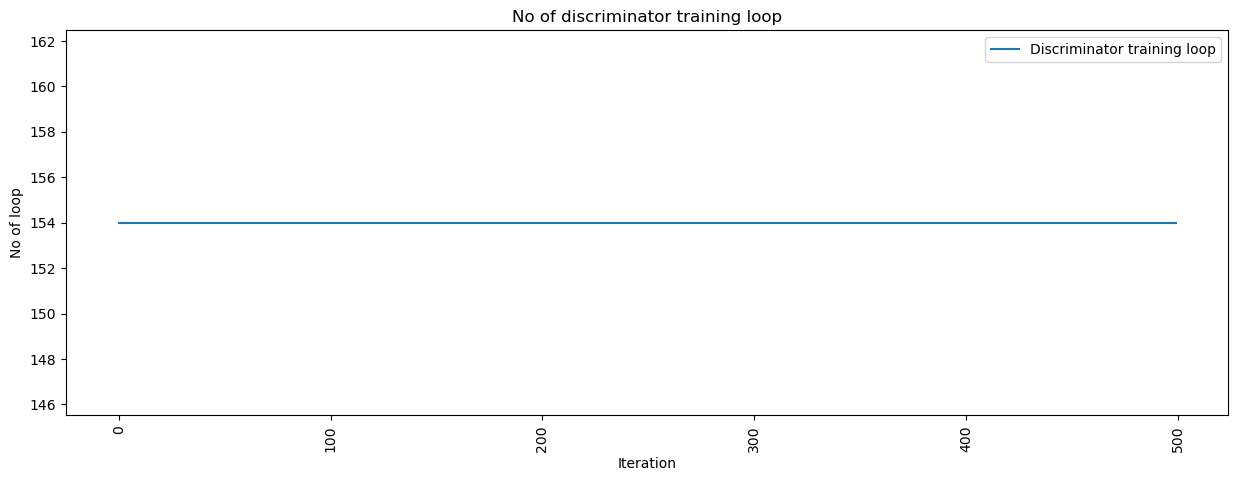

In [25]:
%%time
#acc = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(n_critic, label="Discriminator training loop")

plt.xticks(rotation=90)

plt.title("No of discriminator training loop")
plt.xlabel("Iteration")
plt.ylabel("No of loop")
plt.legend()

In [26]:
n_critic[-1]

154

In [27]:
len(n_critic)

500

In [28]:
name = str('%s/' + 'n_critic_CGAN' + str(len(n_critic))) % MODEL_DIR
np.save(name, n_critic)

In [29]:
%%time
def sample_data(amount):

    # Sample random noise
    z = np.random.normal(0, 1, (amount * 5, z_dim))

    # Get image labels 0-4
    label = np.arange(0, 5)
    labels = np.tile(label, amount).reshape(-1, 1)

    # Generate images from random noise
    gen_data = generator.predict([z, labels], verbose=0)

    fake = np.ones((amount, 1)) * 0

    real_fake = discriminator.predict([gen_data, labels], verbose=0)

    # Rescale image pixel values to [0, 1]
    gen_data = 0.5 * gen_data + 0.5

    return gen_data, labels, real_fake

CPU times: total: 0 ns
Wall time: 0 ns


In [30]:
gen_data, labels, real_fake = sample_data(2000)

In [31]:
gen_data = np.reshape(np.array(gen_data), (gen_data.shape[0], gen_data.shape[1]))

df_generated=pd.DataFrame(data=gen_data[0:,0:], index=[i for i in range(gen_data.shape[0])], columns=[str(i) for i in range(gen_data.shape[1])])

df_generated['label'] = labels

df_generated['real'] = real_fake

df_generated

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,label,real
0,0.910645,0.708984,0.398438,0.044189,0.094727,0.112061,0.150635,0.234619,0.337158,0.056152,...,0.000000,0.000000,0.000000,0.000000,0.006104,0.000000,0.000000,0.002197,0,0.402588
1,1.000000,1.000000,0.908203,0.000000,0.899414,0.267822,0.838867,0.582520,0.009033,0.086670,...,0.000000,0.000000,0.007324,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.771484
2,0.892578,0.868164,0.519043,0.389893,0.190918,0.181641,0.428467,0.362793,0.240479,0.308105,...,0.000000,0.000000,0.000244,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.488525
3,0.999512,0.997559,0.534180,0.384766,0.128174,0.141113,0.087646,0.122314,0.190430,0.114014,...,0.000000,0.000000,0.000732,0.000000,0.000000,0.000000,0.000977,0.000000,3,0.525879
4,0.690430,0.955078,0.527832,0.608398,0.348633,0.344238,0.248779,0.275879,0.331543,0.203369,...,0.000488,0.000732,0.000488,0.000977,0.004395,0.000488,0.004639,0.003174,4,0.576660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.724609,0.777832,0.484131,0.230957,0.148193,0.198730,0.158691,0.275391,0.326172,0.112549,...,0.000244,0.000244,0.000244,0.000732,0.000732,0.000244,0.000488,0.000977,0,0.559082
9996,1.000000,0.999023,0.693359,0.000000,0.414551,0.250977,0.373047,0.256104,0.037842,0.187256,...,0.000000,0.000000,0.002197,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.482178
9997,0.879883,0.831055,0.480713,0.398438,0.271973,0.253174,0.262207,0.161865,0.314453,0.180664,...,0.000000,0.000000,0.000244,0.000000,0.000000,0.000000,0.000244,0.000000,2,0.530762
9998,1.000000,0.974609,0.498535,0.318848,0.244629,0.174805,0.143311,0.100342,0.089600,0.134766,...,0.000000,0.000000,0.000732,0.000000,0.000000,0.000488,0.000732,0.000000,3,0.541992


In [35]:
df_filtered = df_generated[(df_generated.real >= 0.60)]

In [36]:
df_filtered["label"].value_counts()

label
4    223
3    156
0     84
2     71
1     39
Name: count, dtype: int64

CPU times: total: 688 ms
Wall time: 995 ms


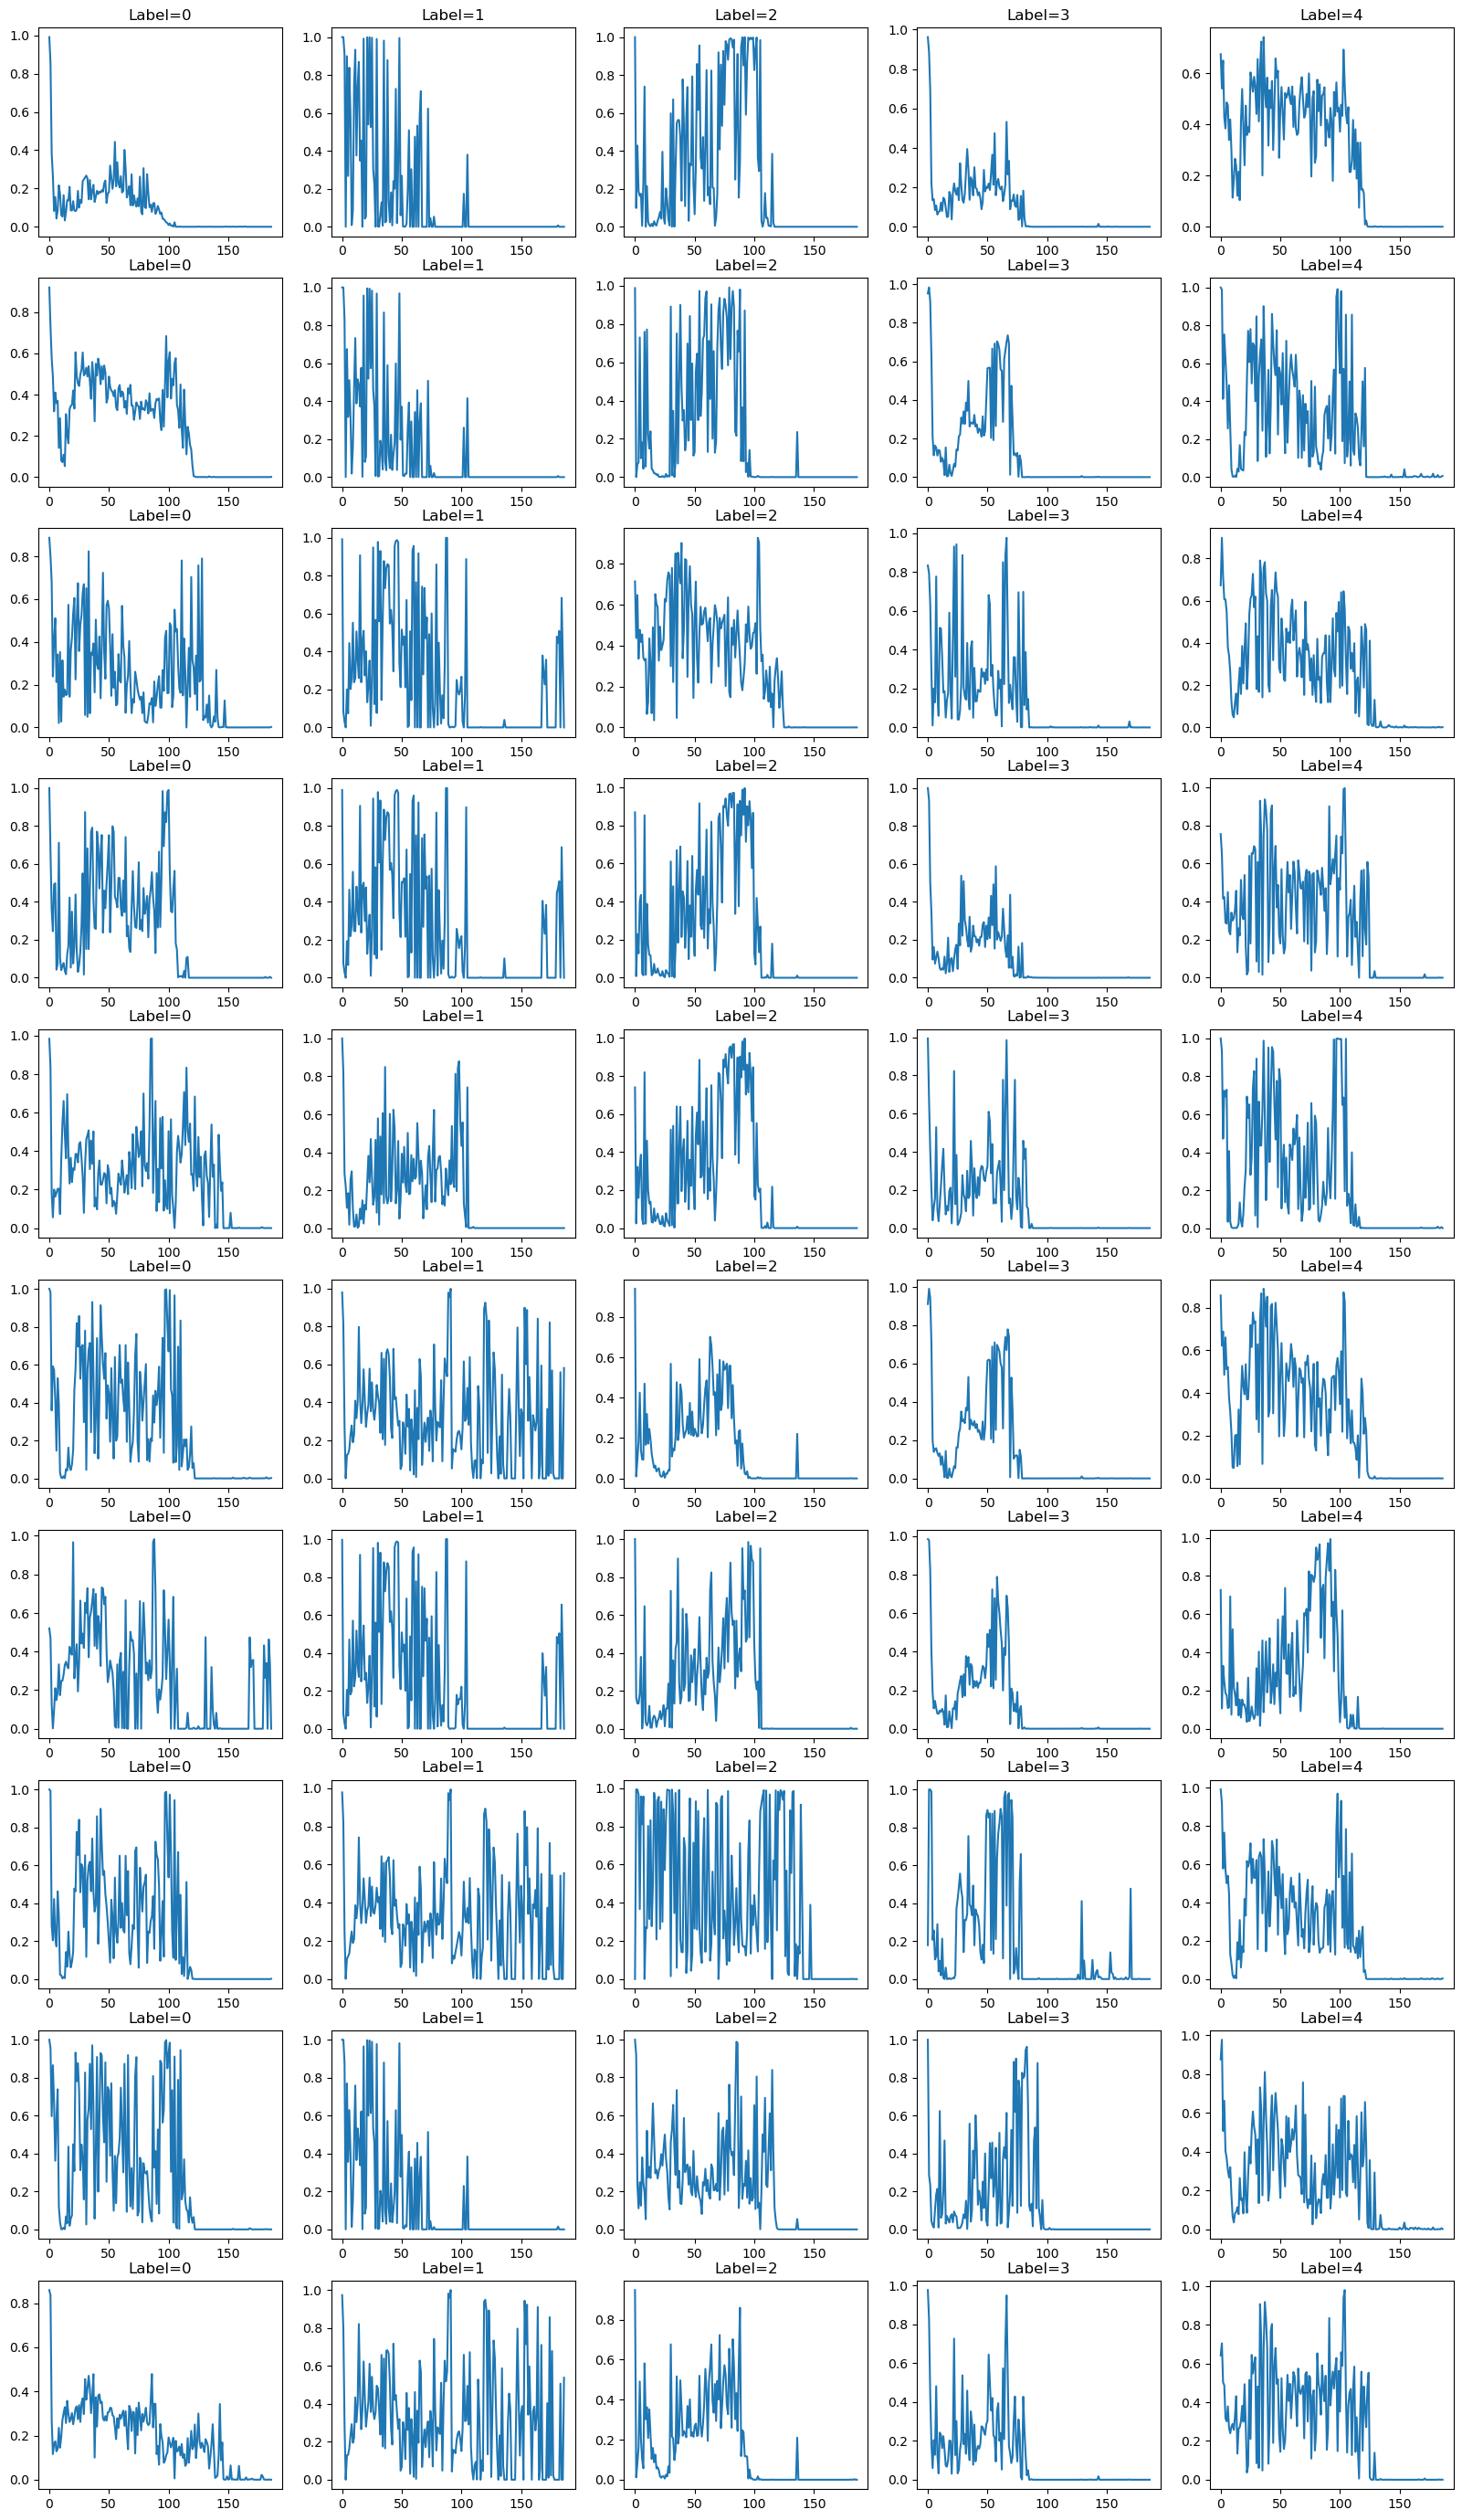

In [37]:
%%time
labels = [0, 1, 2, 3, 4]

n_to_view = 10
fig, axs = plt.subplots(n_to_view, 5, figsize=(20, 35))
for label in labels:
    label_df = df_filtered[df_filtered["label"] == label]
    for i in range(n_to_view):
        data = label_df.drop(['label', 'real'], axis=1).iloc[i].values
        axs[i, label].plot(range(len(data)), data)
        axs[i, label].set_title(f"Label={label}")